In [1]:
import os
from pathlib import Path
import glob
from datetime import datetime

import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torch.utils
import torchvision as tv
from torchvision import transforms as tf

from fastai.vision import *
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

In [2]:
import sys
sys.path.append('../')

In [3]:
from utils_ import *
from io_ import *
from data_ import *
from transforms import *
from models import *
from training import *
from visualizations import *
from monitoring import *
%reload_ext autoreload
%autoreload 2

In [4]:
CLASS_NAMES = ['building', 'tree', 'low-vegetation', 'clutter', 'car', 'pavement']
NCLASSES = len(CLASS_NAMES)

In [5]:
S3_BUCKET = 'raster-vision-ahassan'
S3_ROOT = f'potsdam/experiments/output/tmp'

In [6]:
io_handler = S3IoHandler(
    local_root='tmp', 
    s3_bucket=S3_BUCKET, 
    s3_root=S3_ROOT
)

# Data

In [7]:
with open('../../potsdam/data/potsdam.pkl', 'rb') as f:
    potsdam_dict = pickle.load(f)


## Prepare datasets

In [8]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
CHIP_SIZE = 400
STRIDE = 200
DOWNSAMPLING = 2

In [9]:
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)

In [10]:
original_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform)
train_ds    = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=train_transform, x_tf=x_transform, y_tf=y_transform)
val_ds      = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)

In [11]:
TRAIN_SPLIT = 0.85
train_split_size = int((len(train_ds) * TRAIN_SPLIT) // 1)
val_split_size = len(train_ds) - train_split_size
train_split_size, val_split_size

print('train_split_size', train_split_size)
print('val_split_size', val_split_size)

inds = np.arange(len(train_ds))

train_split_size 12867
val_split_size 2271


In [12]:
train_sampler = torch.utils.data.SubsetRandomSampler(inds[:train_split_size])
val_sampler = torch.utils.data.SubsetRandomSampler(inds[train_split_size:])

assert len(set(train_sampler.indices) & set(val_sampler.indices)) == 0

In [13]:
val_iter = iter(val_sampler)

# Elevation only

In [14]:
# val_idx = next(val_iter)
val_idx = 13028

In [15]:
model_e = get_deeplab_custom(NCLASSES, in_channels=1, pretrained=True)

In [17]:
name = 'ss_e_deeplab_resnet101p__bsz_16'
io_handler.load_model_weights(
    model_e, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

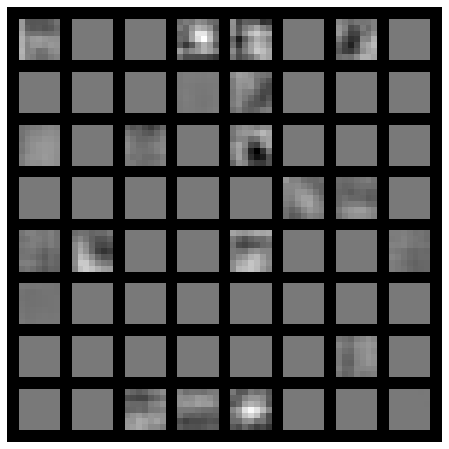

In [18]:
viz_conv_layer_filters(model_e.m.backbone.conv1.weight.data, show=True, normalize=True, scale_each=False, figsize=(8, 8))


------------------------------------------- Input image -------------------------------------------



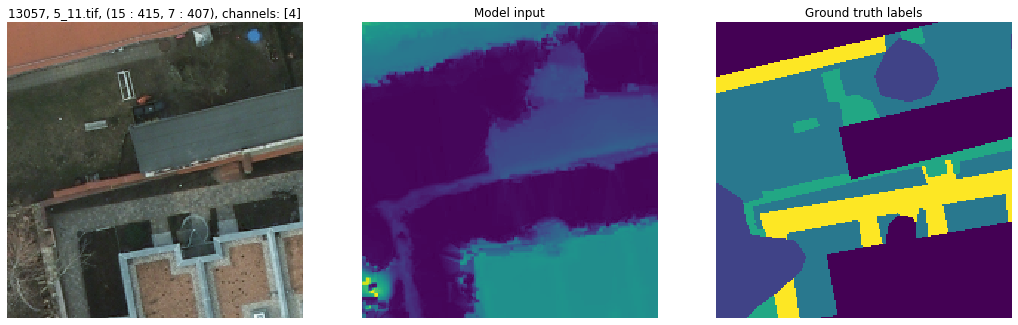


------------------------------------------- Layer-wise output -------------------------------------------


------------------------------------------- Final prediction -------------------------------------------



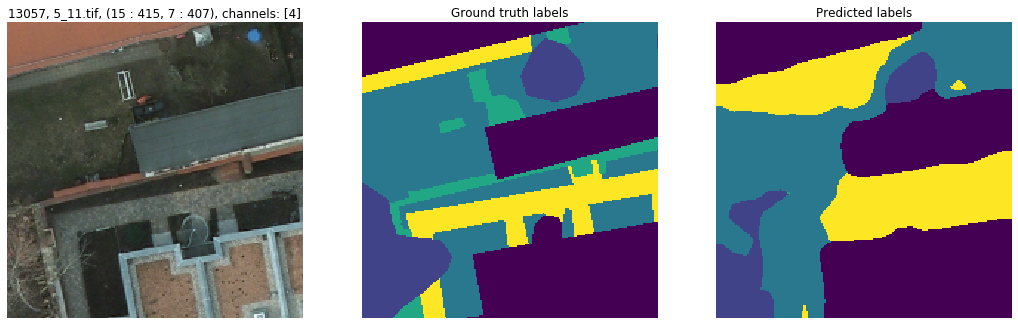

In [50]:
CHANNELS = [ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=2)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform, x_tf=x_transform, y_tf=y_transform)
model_debug(model_e, original_ds, val_ds, val_idx+30-1, channels=CHANNELS, max_depth=0)

# RGB only

In [24]:
model_rgb = get_deeplab_custom(NCLASSES, in_channels=3, pretrained=True).cuda()

In [61]:
name = 'ss_rgb_deeplab_resnet101p'
io_handler.load_model_weights(
    model_rgb, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

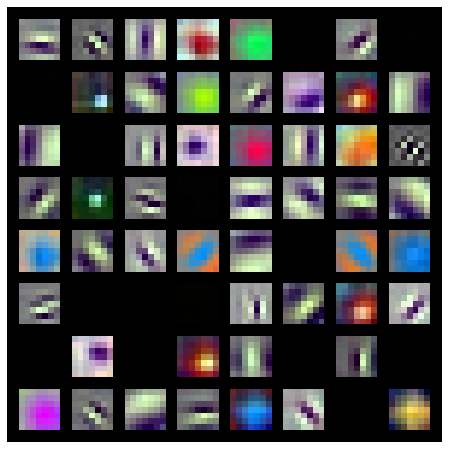

In [62]:
viz_conv_layer_filters(model_rgb.m.backbone.conv1.weight.data, show=True, normalize=True, scale_each=True, figsize=(8, 8))


------------------------------------------- Input image -------------------------------------------



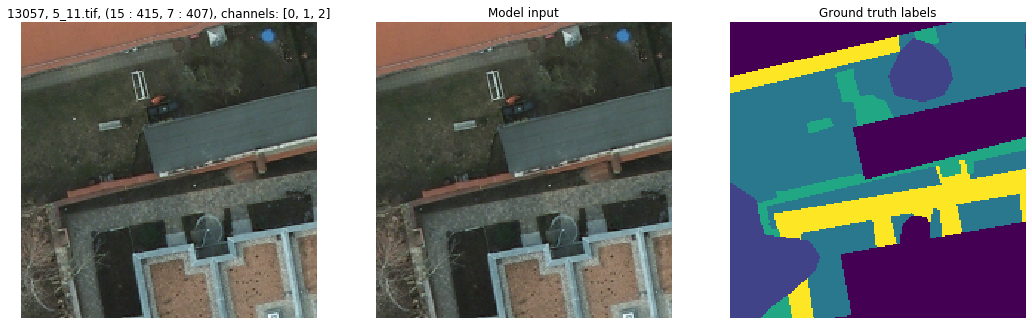


------------------------------------------- Layer-wise output -------------------------------------------


------------------------------------------- Final prediction -------------------------------------------



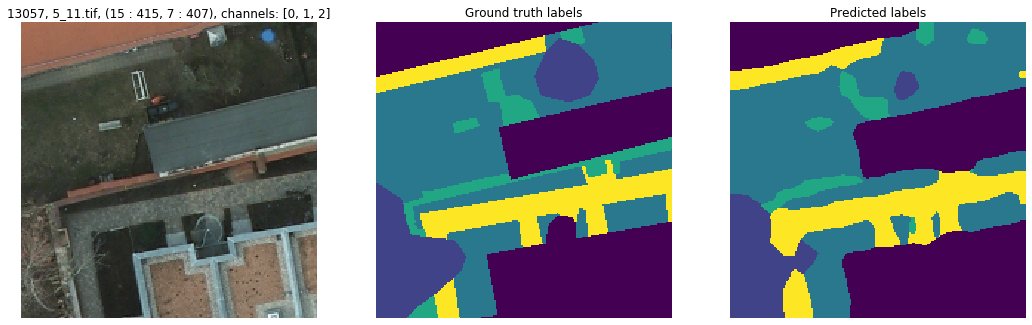

In [77]:
CHANNELS = [ch_R, ch_G, ch_B]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
original_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(model_rgb, original_ds, val_ds, val_idx+30-1, channels=CHANNELS, max_depth=0)

# RGB-E, 1x1

In [10]:
body = create_body(_base_model, pretrained=False)
model_rgbe_1x1 = models.unet.DynamicUnet(body, n_classes=NCLASSES, last_cross=False).cuda()

In [11]:
model_rgbe_1x1[0][0] = ModifiedConv(model_rgbe_1x1[0][0], new_conv_in_channels=1, new_conv_out_channels=64, out_channels=64).cuda()

In [12]:
name = 'ss_rgb_e_unet_resnet18p_lc_False_bsz_16'

In [13]:
io_handler.load_model_weights(
    model_rgbe_1x1, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [ ]:
viz_conv_layer_filters(model_rgbe_1x1[0][0].new_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))
viz_conv_layer_filters(model_rgbe_1x1[0][0].original_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))


In [28]:
isinstance(model_rgbe_1x1[0][0], (nn.Sequential, nn.ModuleList, ModifiedConv))

True


------------------------------------------- Input image -------------------------------------------




------------------------------------------- Layer-wise output -------------------------------------------

Layer: ModifiedConv(
  (original_conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (new_conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bnrelu): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): ReLU()
  )
  (onexone): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
)
Output shape: torch.Size([64, 1, 100, 100])


Layer: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([64, 1, 100, 100])


Layer: ReLU(inplace)
Output shape: torch.Size([64, 1, 100, 100])


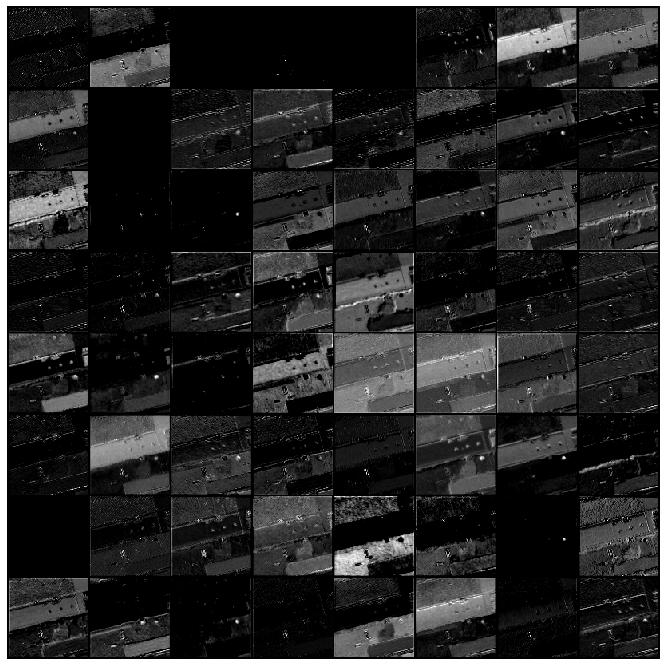

Layer: MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
Output shape: torch.Size([64, 1, 50, 50])


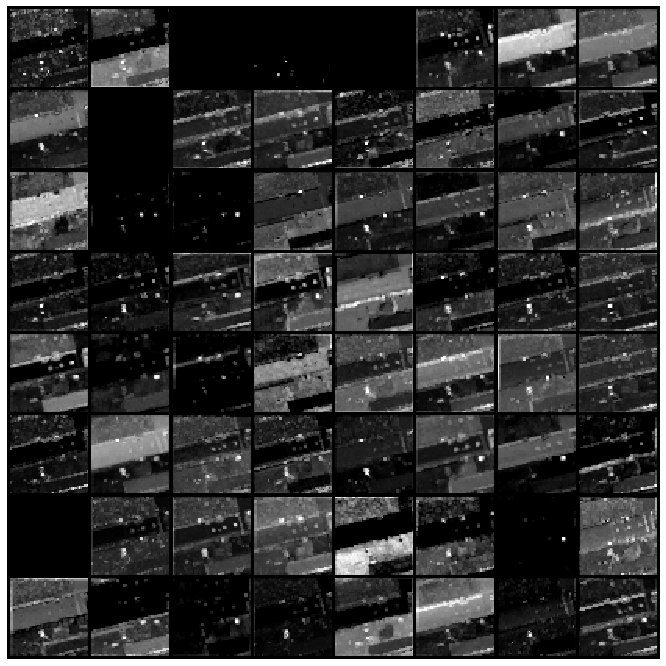

Layer: BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([512, 1, 7, 7])


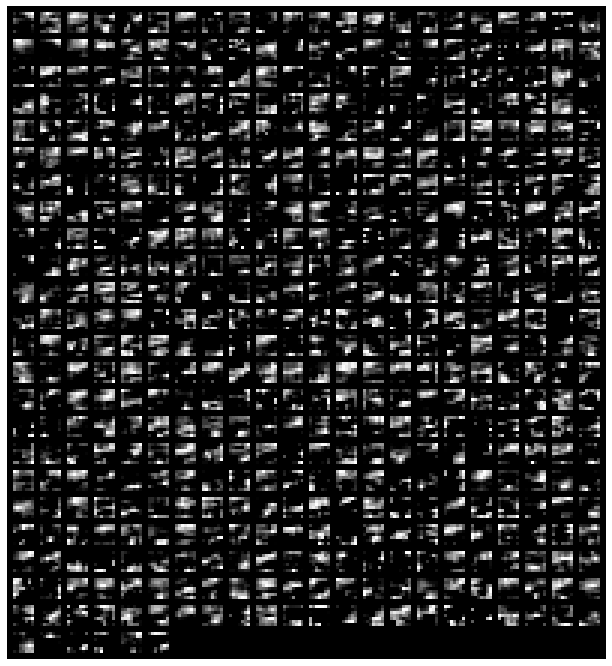

Layer: ReLU()
Output shape: torch.Size([512, 1, 7, 7])


Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([512, 1, 13, 13])


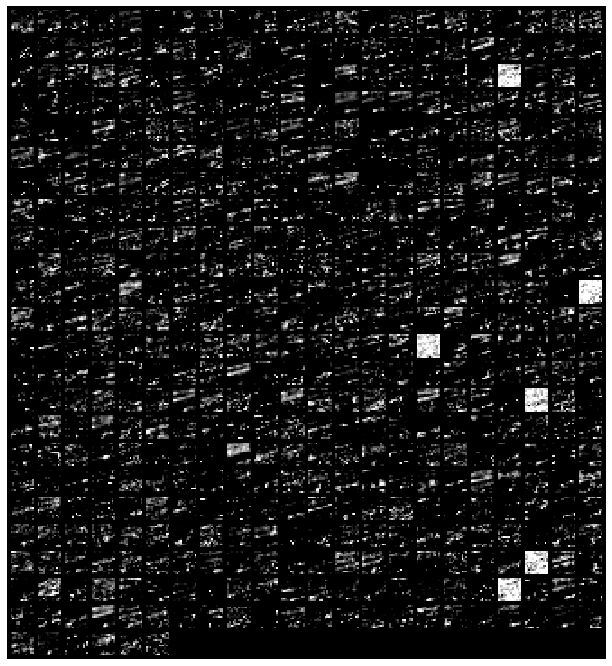

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([384, 1, 25, 25])


Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(384, 768, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([256, 1, 50, 50])


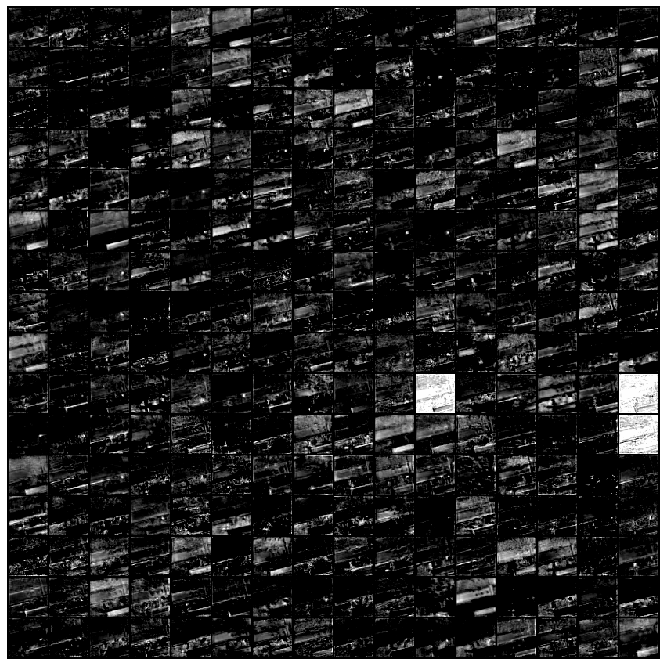

Layer: UnetBlock(
  (shuf): PixelShuffle_ICNR(
    (conv): Sequential(
      (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
    )
    (shuf): PixelShuffle(upscale_factor=2)
    (pad): ReplicationPad2d((1, 0, 1, 0))
    (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
    (relu): ReLU(inplace)
  )
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Sequential(
    (0): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU(inplace)
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu): ReLU()
)
Output shape: torch.Size([96, 1, 100, 100])


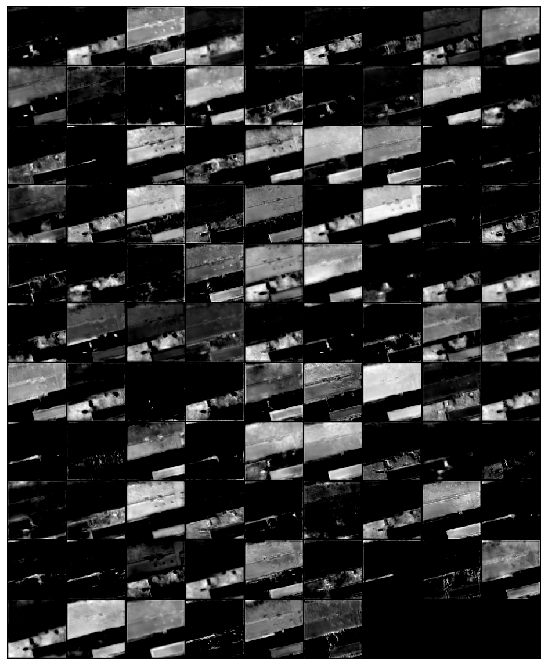

Layer: PixelShuffle_ICNR(
  (conv): Sequential(
    (0): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1))
  )
  (shuf): PixelShuffle(upscale_factor=2)
  (pad): ReplicationPad2d((1, 0, 1, 0))
  (blur): AvgPool2d(kernel_size=2, stride=1, padding=0)
  (relu): ReLU(inplace)
)
Output shape: torch.Size([96, 1, 200, 200])


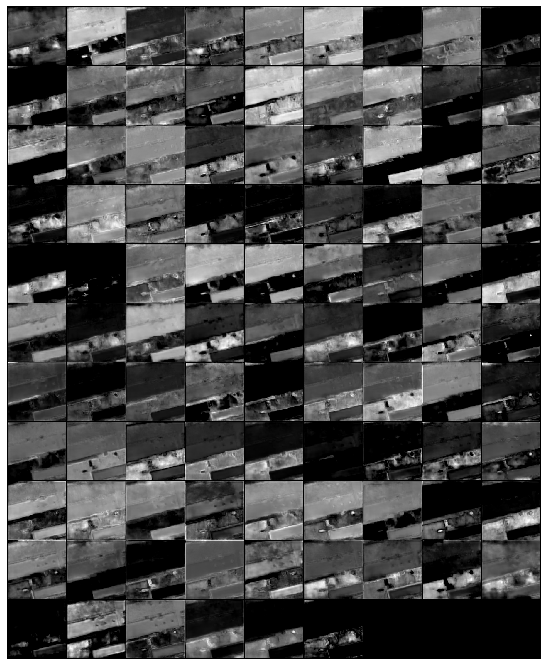

Layer: Conv2d(96, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
Output shape: torch.Size([6, 1, 200, 200])


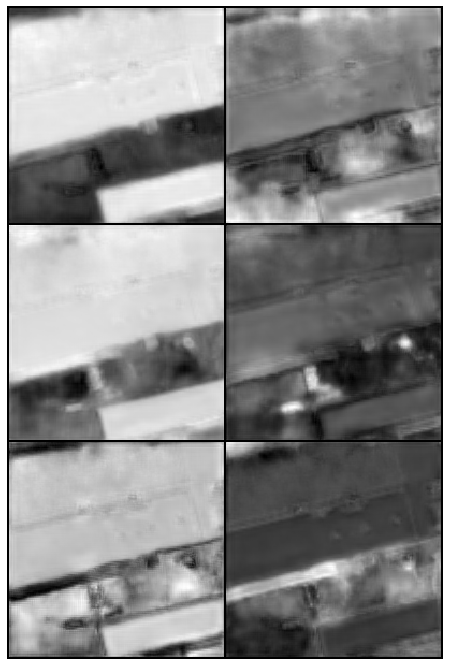

Layer: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Output shape: torch.Size([6, 1, 200, 200])


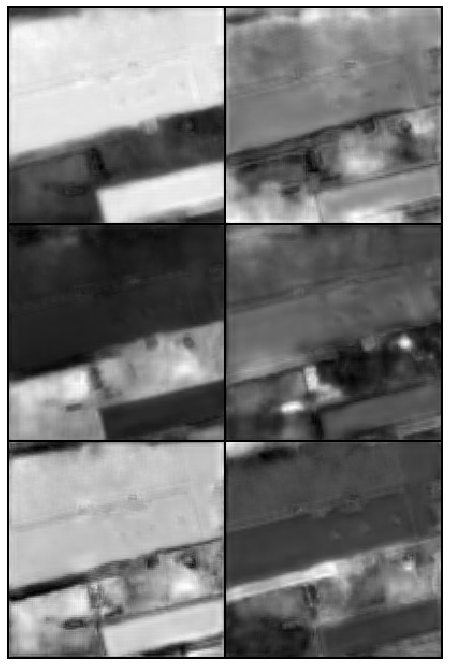


------------------------------------------- Final prediction -------------------------------------------



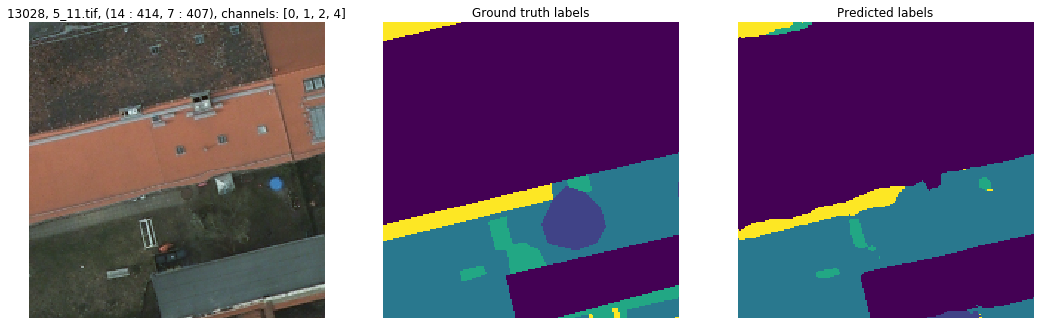

In [32]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(model_rgbe_1x1, original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=2, recurse_whitelist=(nn.Sequential, nn.ModuleList, ModifiedConv))

# RGB-E, 1x1 bnrelu

In [26]:
body = create_body(_base_model, pretrained=False)
model_rgbe_1x1_2 = models.unet.DynamicUnet(body, n_classes=NCLASSES, last_cross=False).cuda()

In [27]:
model_rgbe_1x1[0][0] = ModifiedConv_alt(model_rgbe_1x1_2[0][0], model_rgbe_1x1_2[0][1], new_conv_in_channels=1, new_conv_out_channels=64, out_channels=64).cuda()

In [28]:
name = 'ss_rgb_e_unet_resnet18p_lc_False_bnrelu_fixed_bsz_16'

In [ ]:
io_handler.load_model_weights(
    model_rgbe_1x1, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [ ]:
viz_conv_layer_filters(model_rgbe_1x1[0][0].new_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))
viz_conv_layer_filters(model_rgbe_1x1[0][0].original_conv.weight.data, show=True, normalize=True, scale_each=True, figsize=(6, 6))


In [ ]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(model_rgbe_1x1, original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=0)

# RGB-E, one conv

In [27]:
body = create_body(_base_model, pretrained=False)
model_rgbe_oneconv = models.unet.DynamicUnet(body, n_classes=NCLASSES, last_cross=False).cuda()

In [28]:
old_conv_weights = model2[0][0].weight.data
old_conv_weights.shape

torch.Size([64, 3, 7, 7])

In [29]:
model_rgbe_oneconv[0][0] = nn.Conv2d(4, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False).cuda()

In [30]:
model_rgbe_oneconv[0][0].weight.data[:, :3] = old_conv_weights

In [31]:
name = 'ss_rgb_e_unet_resnet18p_one_conv_bsz_16'
io_handler.load_model_weights(
    model2, 
    s3_path=f'potsdam/experiments/output/{name}/best_model/best_acc', 
    tgt_path=f'models/{name}'
)

In [32]:
def viz_conv_filter_decompose(fs, break_at=3, title='', normalize=True, scale_each=True, show=False, figsize=(16, 10), **kwargs):
    fs1 = fs[:, :break_at]
    fs2 = fs[:, break_at:]
    grid1 = tv.utils.make_grid(fs1, normalize=normalize, scale_each=scale_each, **kwargs).permute(1, 2, 0)
    grid2 = tv.utils.make_grid(fs2, normalize=normalize, scale_each=scale_each, **kwargs).permute(1, 2, 0)

    fig = plt.figure(figsize=figsize)
    plt.title(title)
    plt.axis('off')

    ax1 = fig.add_subplot(121)
    ax1.imshow(grid1)
    ax1.axis('off')

    ax2 = fig.add_subplot(122)
    ax2.imshow(grid2)
    ax2.axis('off')

    if show:
        plt.show()
    else:
        return fig # remember to close figure after use

In [ ]:
viz_conv_filter_decompose(model_rgbe_oneconv[0][0].weight.data, show=True, normalize=True, scale_each=False, figsize=(12, 6))


------------------------------------------- Input image -------------------------------------------



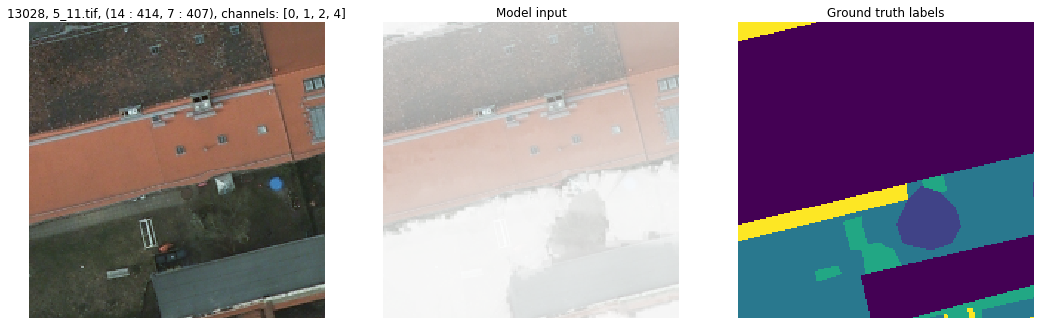


------------------------------------------- Layer-wise output -------------------------------------------


------------------------------------------- Final prediction -------------------------------------------



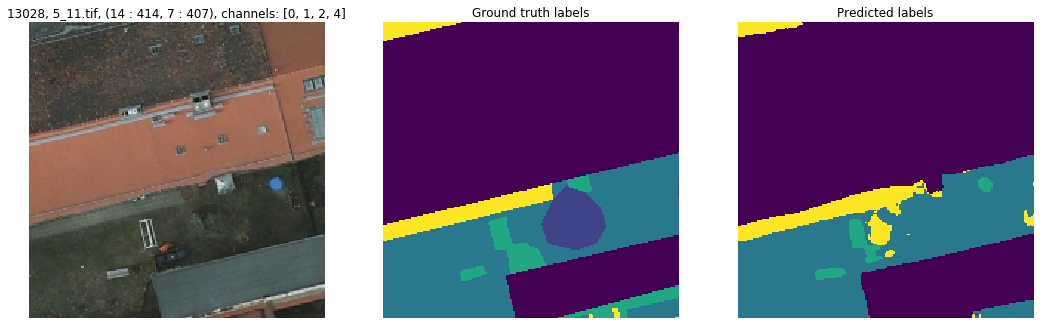

In [115]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(model_rgbe_oneconv, original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=0)

In [43]:
class DeepLabWrapper(nn.Module):
	def __init__(self, m):
		super(DeepLabWrapper, self).__init__()
		self.m = m
	
	def forward(self, X):
		return self.m(X)['out']

In [45]:
model_deeplab_rgb2e = DeepLabWrapper(torch.load('/home/adeel/Downloads/deeplab_resnet101_rgbe2coco(1).pth'))

In [69]:
type(model_deeplab_rgb2e)
# type(list(model_deeplab_rgb2e.m.children())[1])


__main__.DeepLabWrapper

In [ ]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)
val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(list(model_deeplab_rgb2e.m.children())[0], original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=5, recurse_whitelist=(nn.Sequential, nn.ModuleList, DeepLabWrapper, tv.models._utils.IntermediateLayerGetter))

In [106]:

class Customtf(object):
    def __call__(self, arr):
        rgb = arr[:3]
        e = arr[3:]
        rgb_normalized = tv.transforms.functional.normalize(rgb, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        return torch.cat([rgb_normalized, e], dim=0)



In [113]:
class OutThing(nn.Module):
	
	def forward(self, X):
		return X['out']

In [118]:
model_deeplab_rgb2e.m.classifier[-1]

Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))

In [117]:
model_deeplab_rgb2e.m.aux_classifier

FCNHead(
  (0): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1)
  (4): Conv2d(256, 6, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
CHANNELS = [ch_R, ch_G, ch_B, ch_E]
train_transform, val_transform, x_transform, y_transform = tfs_potsdam(channels=CHANNELS, downsampling=DOWNSAMPLING)

x_transform = tv.transforms.Compose([x_transform, Customtf()])

val_ds = Potsdam(potsdam_dict, chip_size=CHIP_SIZE, stride=STRIDE, tf=val_transform  , x_tf=x_transform, y_tf=y_transform)
model_debug(model_deeplab_rgb2e, original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=5, recurse_whitelist=(nn.Sequential, nn.ModuleList, DeepLabWrapper, tv.models._utils.IntermediateLayerGetter))
# model_debug(nn.Sequential(model_deeplab_rgb2e.m.backbone, OutThing(), model_deeplab_rgb2e.m.classifier), original_ds, val_ds, val_idx, channels=CHANNELS, max_depth=5, recurse_whitelist=(nn.Sequential, nn.ModuleList, DeepLabWrapper, tv.models._utils.IntermediateLayerGetter))

In [ ]:
model_deeplab_rgb2e.eval()

out = model_deeplab_rgb2e(val_ds[1][0])
out.shape